## Identifying Potential Locations to Establish an Armenian Restaurant in São Paulo, Brazil

## Table of contents
* [1 - Introduction](#introduction)
* [2 - Business Problem](#problem)
* [3 - Data](#data)
* [4 - Methodology](#methodology)
* [5 - Analysis](#analysis)
* [6 - Results and Discussion](#results)
* [7 - Conclusion](#conclusion)

## 1 - Introduction <a name="introduction"></a>

The distinctness of Armenian nation has found expression in a great number of aspects: the language (a one-language language group within the Indo-European language family, with two standardized forms: Eastern and Western); the alphabet (own alphabet of 39 letters, that centuries ago was also used as a numerical system by Armenians); the Church (Armenian Apostolic). Another distinctive feature is the Armenian Diaspora. Armenians, along with Jews, represent a rare example of a nation, the majority of whose representatives live outside the homeland.

The total number of Armenians residing in Armenia, according to UN data, is around 3 million, whereas the number of those outside is estimated to be, according to different sources, 6-7 million. Jews abiding in Israel total 5.9 million, whereas the Jewish Diaspora comprises more than 7 million people . The biggest Diasporas in the world are Chinese and Indian, but they do not by any means exceed the populations in their respective countrie
s as in the two cases mentioned above.

Today the largest Armenian communities are in Russia (2.25 million), USA (1.5 million), France (about 450,000). Other significant communities are in Georgia, Argentina, Lebanon, Iran, Poland, Ukraine, Germany, Australia, __Brazil__ and Canada. Another very important community used to exist in Syria, but after recent events most Armenians have fled the country, many of them asking for residency in Armenia.

The key objective of this project is to help a group of investors to identify potential locations in São Paulo, Brazil, in order to establish an Armenian restaurant, targeting its efforts not only to Armenian-origin residents but also to other market segments with long-lasting historical relatonships with armenians. Our particular interest will be in neighbourhoods where there is already a strong gastronomic tradition, but that does not include an existing Armenian restaurant or other restaurants known for their Greek and Arab traditions.   

## 2 - The Business Problem <a name="problem"></a>

São Paulo is a cosmopolitan city where restaurants of all types and origins abound. Our particular interest will be in neighborhoods where there is already a gastronomic tradition, but that does not include other Greek and Arab-food restaurants, the latter including the Syrian and Lebanese cuisine.

Data science-based techniques will be employed to generate potential and promissing neighborhoods candidates. Advantages of each areas will then be clearly expressed so that best possible final location can be chosen by the stakeholders.

## 3 - Data <a name="data"></a>

Based upon the stated business-problem, data sources will be needed to extract/generate the required information:

* Geolocation coordinates of candidate areas will be generated, and 
* The number of restaurants and their type and location in every neighborhood will be obtained using available resources of   __Foursquare API__.

## 4 - Methodology <a name="methodology"></a>

The methodology in this project will consist in the following steps:
* Import all needed libraries;
* Retrieve the geolocation coordinates of all boroughs and neighbourhoods that comprise the municipality of São Paulo;
* Visualize those neighbourhoods through __folium maps__;
* Adopting the "Elbow method" and the k-means classifier, explore the characteristics of those neighbourhoods in order to identify distinct clusters that might be attractive to host an Armenian restaurant;
* Through queries to __Foursquare API__, list all categories of restaurants aiming at identifying potential competing restaurants and their geolocations;
* Determine the gastronomic activity of each neighbourhood, selecting those that are more active and presenting low competition levels;
* Finally, suggest to the group of investors the potential neighbourhood candidates. 

## 5 - Analysis <a name="analysis"></a>

In [1]:
# Importing the needed libraries 
import numpy as np 
import pandas as pd
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

print('Libraries imported.')

Libraries imported.


In [2]:
# Retrieve the geolocation coordinates of all boroughs and neighborhoods that comprise the municipality of São Paulo
# Dataset source: https://github.com/ekoga/Coursera_Capstone/commit/215b5b8f980a07e5d025417dfbeab1a8e2e8154e
spneighborhoods = pd.read_csv('saopaulo_neighborhoods.csv')
spneighborhoods

,Borough,Neighborhood,Latitude,Longitude
0,Centro,Bela Vista,-23.552128,-46.635161
1,Centro,Bom Retiro,-23.525656,-46.651618
2,Centro,Cambuci,-23.565619,-46.630160
3,Centro,Consolacao,-23.554083,-46.655463
4,Centro,Liberdade,-23.565311,-46.641115
...,...,...,...,...
92,Sul,Campo Grande,-23.678069,-46.695992
93,Sul,Santo Amaro,-23.644649,-46.721156
94,Sul,Moema,-23.602067,-46.674205
95,Sul,Saude,-23.617997,-46.640638


In [3]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(spneighborhoods['Borough'].unique()),
        spneighborhoods.shape[0]))

The dataframe has 5 boroughs and 97 neighborhoods.


In [4]:
# Getting the Sao Paulo geographical coordinates
address = 'São Paulo, SP, BR'

geolocator = Nominatim(user_agent="sp_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of São Paulo City are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of São Paulo City are -23.5506507, -46.6333824.


In [5]:
# Creating São Paulo's map using latitude and longitude parameters
map_saopaulo = folium.Map(location=[latitude, longitude], zoom_start=10)

# Adding markers
for lat, lng, borough, neighborhood in zip(spneighborhoods['Latitude'], spneighborhoods['Longitude'],
spneighborhoods['Borough'], spneighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_saopaulo)  
    
map_saopaulo

In [6]:
# Passing the needed parameters to Foursquare API
CLIENT_ID = 'ZRWGHUVUMM3JQIYJYJRUXN1WKGFAPSDKMJN0GTNSTRNRJAOR' 
CLIENT_SECRET = 'DEXV3CHRRQ5DIGNYYI4HY1NU1B0PQIFKCJMPEMB2ZEFNFIQH'
VERSION = '20180605'
LIMIT = 100 # This is the default Foursquare API limit value

Exploring the neighborhoods of São Paulo.

In [7]:
# Creating a function the will retrieve the venues aroun each neighborhood.
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
sp_venues = getNearbyVenues(names = spneighborhoods['Neighborhood'],
latitudes=spneighborhoods['Latitude'],
longitudes=spneighborhoods['Longitude'])

Bela Vista
Bom Retiro
Cambuci
Consolacao
Liberdade
Republica
Santa Cecília
Se
Aricanduva
Carrao
Vila Formosa
Cidade Tiradentes
Ermelino Matarazzo
Ponte Rasa
Guaianases
Lajeado
Itaim Paulista
Vila Curuca
Itaquera
Cidade Lider
Jose Bonifacio
Parque do Carmo
Mooca Agua Rasa
Belem
Bras
Moóca
Pari
Tatuape
Penha
Artur Alvim
Cangaíba
Vila Matilde
Sao Mateus
Sao Rafael
Sao Miguel
Jardim Helena
Vila Jacui
Sapopemba
Vila Prudente
Sao Lucas
Casa Verde
Cachoeirinha
Limao
Brasilandia
Freguesia do O
Jaçana
Tremembé
Perus
Anhanguera
Pirituba
Jaragua
Sao Domingos
Santana
Tucuruvi
Mandaqui
Vila Maria
Vila Guilherme
Vila Medeiros
Butanta
Morumbi
Raposo Tavares
Rio Pequeno
Vila Sonia
Lapa
Barra Funda
Jaguara
Jaguare
Perdizes
Vila Leopoldina
Pinheiros
Alto de Pinheiros
Itaim Bibi
Jardim Paulista
Pinheiros
Campo Limpo
Capao Redondo
Vila Andrade
Capela do Socorro Cidade Dutra
Grajau
Socorro
Cidade Ademar
Pedreira
Ipiranga
Sacoma
Jabaquara
MBoi Mirim
Jardim Angela
Jardim Sao Luis
Parelheiros
Marsilac
Santo A

In [9]:
# Checking the size of the resulting data frame
print(sp_venues.shape)
sp_venues

(2328, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bela Vista,-23.552128,-46.635161,Izakayada,-23.553157,-46.635639,Sake Bar
1,Bela Vista,-23.552128,-46.635161,Kopenhagen,-23.551759,-46.635370,Chocolate Shop
2,Bela Vista,-23.552128,-46.635161,Sushi Isao,-23.554134,-46.634245,Sushi Restaurant
3,Bela Vista,-23.552128,-46.635161,Cine Joia,-23.553354,-46.635767,Nightclub
4,Bela Vista,-23.552128,-46.635161,Restaurante Mugui,-23.554111,-46.634212,Japanese Restaurant
...,...,...,...,...,...,...,...
2323,Vila Mariana,-23.590502,-46.652227,Restaurante Caluma,-23.594500,-46.652031,Brazilian Restaurant
2324,Vila Mariana,-23.590502,-46.652227,Quentinho e Fresquinho,-23.590739,-46.648320,Restaurant
2325,Vila Mariana,-23.590502,-46.652227,Pierre Verger,-23.592563,-46.649252,French Restaurant
2326,Vila Mariana,-23.590502,-46.652227,Bem Me Quer Sports,-23.593898,-46.649756,Gym Pool


In [10]:
print('There are {} uniques categories.'.format(len(sp_venues['Venue Category'].unique())))

There are 268 uniques categories.


Analysing each neighborhood.

In [11]:
# One hot encoding
sp_onehot = pd.get_dummies(sp_venues[['Venue Category']], prefix="", prefix_sep="")

# Adding neighborhood column back to dataframe
sp_onehot['Neighborhood'] = sp_venues['Neighborhood'] 

# Moving neighborhood column to the first column
fixed_columns = [sp_onehot.columns[-1]] + list(sp_onehot.columns[:-1])
sp_onehot = sp_onehot[fixed_columns]

print(sp_onehot.shape)
sp_onehot.head()

(2328, 269)


,Neighborhood,Acai House,Accessories Store,Adult Boutique,Airport Service,Airport Terminal,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Bela Vista,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bela Vista,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bela Vista,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bela Vista,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bela Vista,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# For each neighborhood, taking the mean of the frequency of occurrence of each category
sp_grouped = sp_onehot.groupby('Neighborhood').mean().reset_index()
sp_grouped

,Neighborhood,Acai House,Accessories Store,Adult Boutique,Airport Service,Airport Terminal,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Alto de Pinheiros,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016393,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Anhanguera,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aricanduva,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Artur Alvim,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Barra Funda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,Vila Mariana,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.065217,0.043478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,Vila Matilde,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88,Vila Medeiros,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89,Vila Prudente,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Retrieving the top 10 most common venues for each venue
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Creating columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Creating a new dataframe
sp_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
sp_neighborhoods_venues_sorted['Neighborhood'] = sp_grouped['Neighborhood']

for ind in np.arange(sp_grouped.shape[0]):
    sp_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sp_grouped.iloc[ind, :], num_top_venues)

sp_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alto de Pinheiros,Brazilian Restaurant,Bar,Plaza,Paper / Office Supplies Store,Pizza Place,Martial Arts School,Bus Stop,Bakery,Restaurant,Pharmacy
1,Anhanguera,Tennis Court,Soccer Field,Yoga Studio,Food & Drink Shop,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food Court
2,Aricanduva,Bakery,Candy Store,Café,Clothing Store,Gymnastics Gym,Pastelaria,School,Gym,Soccer Stadium,Pet Store
3,Artur Alvim,Pizza Place,Soccer Stadium,Burger Joint,Clothing Store,Tour Provider,Music Venue,Farmers Market,Grocery Store,Stadium,Boxing Gym
4,Barra Funda,Nightclub,Bar,Café,Sandwich Place,Restaurant,Plaza,Bookstore,Brazilian Restaurant,Chocolate Shop,Coffee Shop


Clustering São Paulo neighborhoods.

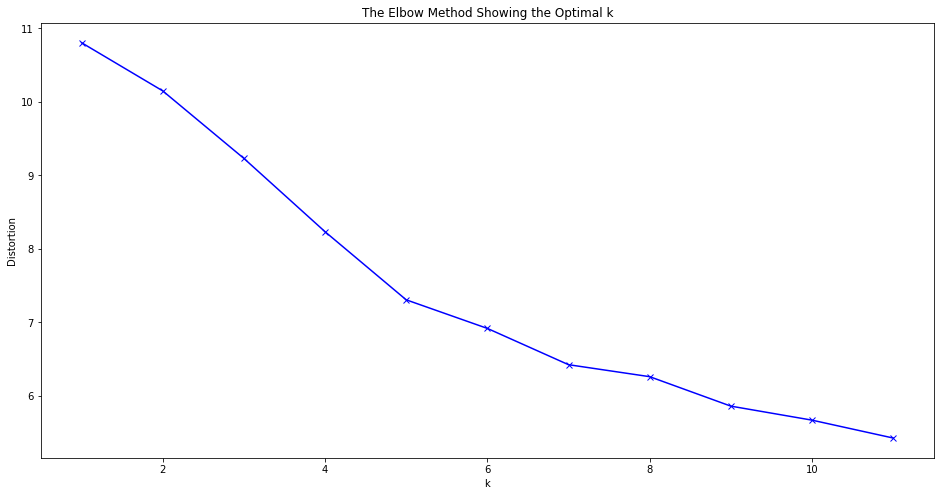

In [14]:
# Determining the optimal number of clusters
sp_grouped_clustered = sp_grouped.drop('Neighborhood', 1)
import matplotlib.pyplot as plt 
distortions = []
K = range(1,12)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(sp_grouped_clustered)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method Showing the Optimal k')
plt.show() 

It seems that 5 is the optimal number of clusters

In [15]:
kclusters = 5
# Run k-means clustering algorithm
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(sp_grouped_clustered)

In [16]:
# Adding clustering labels
sp_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sp_merged = spneighborhoods

# Merging datasets datasets to add latitude/longitude for each neighborhood
sp_merged = sp_merged.join(sp_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

sp_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Centro,Bela Vista,-23.552128,-46.635161,0.0,Cosmetics Shop,Japanese Restaurant,Bookstore,Bakery,Grocery Store,Vegetarian / Vegan Restaurant,Gift Shop,Nightclub,Miscellaneous Shop,Arts & Crafts Store
1,Centro,Bom Retiro,-23.525656,-46.651618,0.0,Dive Bar,Pizza Place,Brazilian Restaurant,Café,Rental Car Location,Public Art,Food Stand,Bus Stop,Music Venue,Coffee Shop
2,Centro,Cambuci,-23.565619,-46.630160,0.0,Pizza Place,Bakery,Pet Store,Pharmacy,Bar,Brazilian Restaurant,Grocery Store,BBQ Joint,Market,Chinese Restaurant
3,Centro,Consolacao,-23.554083,-46.655463,0.0,Brazilian Restaurant,Café,Bar,Dance Studio,Pet Store,Theater,Burger Joint,Coffee Shop,Gym / Fitness Center,Japanese Restaurant
4,Centro,Liberdade,-23.565311,-46.641115,0.0,Brazilian Restaurant,Bakery,Diner,Hotel,Pizza Place,Coffee Shop,Café,Japanese Restaurant,Snack Place,Bookstore


In [17]:
# Treating cluster labels missing values and converting the format from floating to integer
sp_merged[['Cluster Labels']] = sp_merged[['Cluster Labels']].fillna(0)
sp_merged[['Cluster Labels']] = sp_merged[['Cluster Labels']].astype(int)

In [18]:
# Checking the resulting cluster labels
array = np.array(sp_merged['Cluster Labels'])
array

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

Visualizing the resulting clusters.

In [19]:
# Creating a map
sp_map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Set a color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers
markers_colors = []
for lat, lon, neighbor, cluster in zip(sp_merged['Latitude'], sp_merged['Longitude'], sp_merged['Neighborhood'],
                                  sp_merged['Cluster Labels']):
    label = folium.Popup(str(neighbor) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster -1],
        fill = True,
        fill_color = rainbow[cluster-1],
        fill_opacity = 0.7).add_to(sp_map_clusters)
       
sp_map_clusters

## Analysing Clusters

__Cluster 1__

In [20]:
sp_merged.loc[sp_merged['Cluster Labels'] == 0, sp_merged.columns[[1] + list(range(5, sp_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bela Vista,Cosmetics Shop,Japanese Restaurant,Bookstore,Bakery,Grocery Store,Vegetarian / Vegan Restaurant,Gift Shop,Nightclub,Miscellaneous Shop,Arts & Crafts Store
1,Bom Retiro,Dive Bar,Pizza Place,Brazilian Restaurant,Café,Rental Car Location,Public Art,Food Stand,Bus Stop,Music Venue,Coffee Shop
2,Cambuci,Pizza Place,Bakery,Pet Store,Pharmacy,Bar,Brazilian Restaurant,Grocery Store,BBQ Joint,Market,Chinese Restaurant
3,Consolacao,Brazilian Restaurant,Café,Bar,Dance Studio,Pet Store,Theater,Burger Joint,Coffee Shop,Gym / Fitness Center,Japanese Restaurant
4,Liberdade,Brazilian Restaurant,Bakery,Diner,Hotel,Pizza Place,Coffee Shop,Café,Japanese Restaurant,Snack Place,Bookstore
...,...,...,...,...,...,...,...,...,...,...,...
92,Campo Grande,Brazilian Restaurant,Clothing Store,Steakhouse,Accessories Store,Dessert Shop,Department Store,Café,Gift Shop,Cosmetics Shop,Pharmacy
93,Santo Amaro,Brazilian Restaurant,Mineiro Restaurant,Diner,Sandwich Place,Massage Studio,Furniture / Home Store,Bus Station,Snack Place,Fast Food Restaurant,Music Venue
94,Moema,Bar,Convenience Store,Spa,Pizza Place,Seafood Restaurant,Coffee Shop,Farmers Market,Arts & Crafts Store,Gym,Market
95,Saude,Pet Store,Japanese Restaurant,Pharmacy,Martial Arts School,Farmers Market,Dessert Shop,Pizza Place,Brazilian Restaurant,Restaurant,Bakery


__Cluster 2__

In [21]:
sp_merged.loc[sp_merged['Cluster Labels'] == 2, sp_merged.columns[[1] + list(range(5, sp_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
47,Perus,Ice Cream Shop,Yoga Studio,Food Court,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Stand



__Cluster 3__

In [22]:
sp_merged.loc[sp_merged['Cluster Labels'] == 3, sp_merged.columns[[1] + list(range(5, sp_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Cidade Tiradentes,Athletics & Sports,Yoga Studio,Food Court,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Stand,Farmers Market


__Cluster 4__

In [23]:
sp_merged.loc[sp_merged['Cluster Labels'] == 4, sp_merged.columns[[1] + list(range(5, sp_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Ermelino Matarazzo,Restaurant,Soccer Field,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Yoga Studio,Farm


__Cluster 5__

In [24]:
sp_merged.loc[sp_merged['Cluster Labels'] == 5, sp_merged.columns[[1] + list(range(5, sp_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [25]:
sp_restaurants = sp_venues[sp_venues['Venue Category'].str.contains('Restaurant*') |
                           sp_venues['Venue Category'].str.contains('Bistro') |
                           sp_venues['Venue Category'].str.contains('Armenian') |
                           sp_venues['Venue Category'].str.contains('Arab.*')]
sp_restaurants

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2,Bela Vista,-23.552128,-46.635161,Sushi Isao,-23.554134,-46.634245,Sushi Restaurant
4,Bela Vista,-23.552128,-46.635161,Restaurante Mugui,-23.554111,-46.634212,Japanese Restaurant
5,Bela Vista,-23.552128,-46.635161,Sukiya,-23.554502,-46.635442,Japanese Restaurant
11,Bela Vista,-23.552128,-46.635161,Tanka Asian Kitchen,-23.555325,-46.635397,Asian Restaurant
14,Bela Vista,-23.552128,-46.635161,Chi Fu,-23.554452,-46.635581,Chinese Restaurant
...,...,...,...,...,...,...,...
2309,Vila Mariana,-23.590502,-46.652227,Jabuti,-23.588511,-46.648003,Seafood Restaurant
2313,Vila Mariana,-23.590502,-46.652227,Aquarelle Restaurant,-23.592702,-46.649403,French Restaurant
2323,Vila Mariana,-23.590502,-46.652227,Restaurante Caluma,-23.594500,-46.652031,Brazilian Restaurant
2324,Vila Mariana,-23.590502,-46.652227,Quentinho e Fresquinho,-23.590739,-46.648320,Restaurant


Visualiing the 458 restaurants in the the map.

In [26]:
# Create the map of São Paulo using latitude and longitude values
sp_restaurant_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# Adding markers
for lat, lng, neighborhood, cat in zip(sp_restaurants['Venue Latitude'], sp_restaurants['Venue Longitude'],
                                sp_restaurants['Neighborhood'], sp_restaurants['Venue Category']):
    label = '{}, {}'.format(neighborhood, cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(sp_restaurant_map)  
    
sp_restaurant_map

In [27]:
# Identiying the restaurant categories
sp_restaurants_types = sp_restaurants['Venue Category'].unique()
print(sp_restaurants_types, 'Total of ', len(sp_restaurants_types), ' restaurant categories')

['Sushi Restaurant' 'Japanese Restaurant' 'Asian Restaurant'
 'Chinese Restaurant' 'Vegetarian / Vegan Restaurant'
 'Brazilian Restaurant' 'Ramen Restaurant' 'Italian Restaurant'
 'Korean Restaurant' 'Bistro' 'Thai Restaurant'
 'Middle Eastern Restaurant' 'Baiano Restaurant' 'French Restaurant'
 'Mineiro Restaurant' 'Indian Restaurant' 'Tapas Restaurant'
 'Empanada Restaurant' 'Greek Restaurant' 'Argentinian Restaurant'
 'Restaurant' 'Portuguese Restaurant' 'Latin American Restaurant'
 'Peruvian Restaurant' 'Mediterranean Restaurant' 'Vietnamese Restaurant'
 'Fast Food Restaurant' 'Kosher Restaurant' 'Seafood Restaurant'
 'Szechuan Restaurant' 'Falafel Restaurant' 'Doner Restaurant'
 'Kebab Restaurant' 'Southern Brazilian Restaurant'
 'Northeastern Brazilian Restaurant' 'Mexican Restaurant'
 'American Restaurant' 'German Restaurant'
 'Southeastern Brazilian Restaurant' 'Spanish Restaurant'
 'Dumpling Restaurant' 'Comfort Food Restaurant'
 'Molecular Gastronomy Restaurant' 'Donburi Rest

In [28]:
# Determining the gastronomic activity for each neighborhood and chosing those that host at least 10 restaurants
limit = 10
sp_restaurants_by_neighborhood = sp_restaurants.groupby(['Neighborhood']).size().sort_values(ascending = False).reset_index(name='counts')
sp_restaurants_location_pot = sp_restaurants_by_neighborhood[sp_restaurants_by_neighborhood['counts'] >= limit].set_index('Neighborhood')
sp_restaurants_location_pot

,counts
Neighborhood,
Itaim Bibi,30
Republica,28
Consolacao,24
Pinheiros,18
Santo Amaro,16
Bela Vista,14
Se,14
Pari,13
Liberdade,12


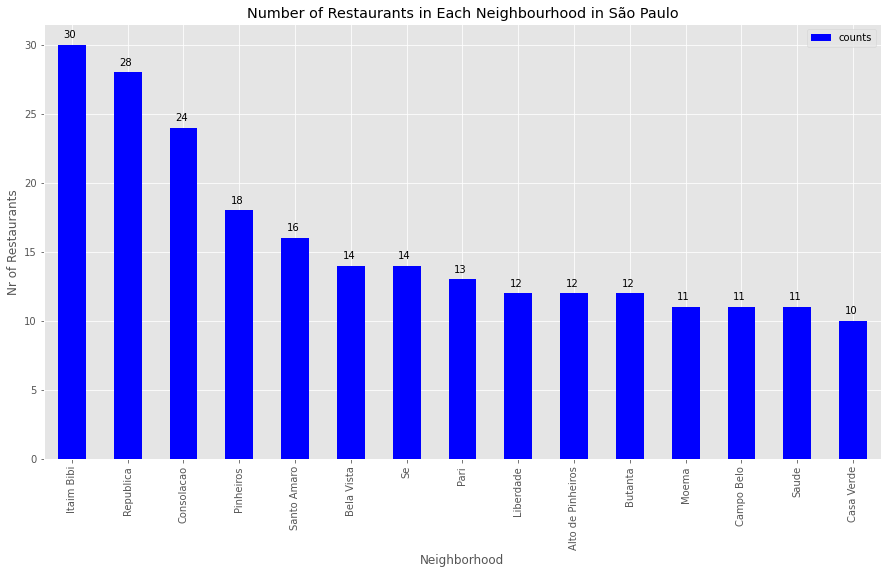

In [29]:
# Plotting the results
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')
ax = sp_restaurants_location_pot.plot(kind='bar', color = 'blue', figsize=(15,8))
x_labels = ['Neighborhood']
plt.title('Number of Restaurants in Each Neighbourhood in São Paulo')
plt.xlabel('Neighborhood')
plt.ylabel('Nr of Restaurants')

for label in ax.patches:
    ax.annotate(format(label.get_height()),
    xy=(label.get_x()+0.10, label.get_height()+0.5))

plt.show()

Finding potential competitors.

In [30]:
competition = sp_restaurants[sp_restaurants['Venue Category'].str.contains('Kebab') |
                           sp_restaurants['Venue Category'].str.contains('Falafel') |
                           sp_restaurants['Venue Category'].str.contains('Armenian')|
                           sp_restaurants['Venue Category'].str.contains('Greek')|  
                           sp_restaurants['Venue Category'].str.contains('Arab.*')]
                           
competition

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
196,Consolacao,-23.554083,-46.655463,Athenas,-23.556665,-46.657800,Greek Restaurant
695,Bras,-23.539216,-46.623544,Rei do Falafel,-23.537243,-46.620218,Falafel Restaurant
764,Pari,-23.527687,-46.615926,istanbul restaurant,-23.529885,-46.617748,Kebab Restaurant
1034,Casa Verde,-23.509847,-46.661482,Super Sheik,-23.507459,-46.661650,Falafel Restaurant


## 6 - Results and Discussion <a name="results"></a>

From the above mentioned analytical procedures, the following observations emerge:
* São Paulo is a pretty much an homogeneous city with a "huge" cluster comprising by the bulk of its neighbourhoods. The distinct clusters are two neighbourhoods at the low-income outskirts of the city and, therefore, not eligible for potential candidates for hosting an Armenian restaurant;
* The 458 restaurants delivered by the queries to the Foursquare API can be grouped into 44 distinct categories that do not include the "Armenian" and "Arab" as well, but include two other categories that indirectly compete with the Armenian cuisine: "Falafel" (2 individuals) and "Kebab" (1 individual);
* Those 3 restaurants mentioned in the preceding comment are in popular neighbourhoods, somewhat far from the gastronomic epicentre frequented by middle and high income class consumers;
* The strongest potential competitor is  a Greek restaurant located within the Sao Paulo's gastronomic belt, in the "Consolação" neighbourhood;
* One strong candidate emerge as the most attractive neighbourhood, "Itaim", popularly known as the charming venue that hosts a bunch of well-known restaurants in São Paulo. 

## 7 - Conclusion <a name="conclusion"></a>

The key conclusion is that "Itaim" neighborhood should be strongly recommended to the group of investors that commissioned this project. A detailed and follow-up study should be carried out, looking in details its micro-regions that can leverage the successful launching of an Armenian restaurant in São Paulo.  